# Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
#Download your api kaggle.jdon from kaggle and upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"noobkoda","key":"2b262f4daf658c3c7fb7ea7698f88a33"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen

100% 3.50G/3.51G [00:48<00:00, 95.4MB/s]
100% 3.51G/3.51G [00:48<00:00, 77.8MB/s]


In [ ]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/tuberculosis-chest-xrays-shenzhen.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Libraries 


In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import splitfolders 
from glob import glob

# Preprocessing

In [ ]:
datainfo = pd.read_csv('/content/shenzhen_metadata.csv')

In [ ]:
datainfo.head()

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [ ]:
normal = []
positive =  []

In [ ]:
def extract_target(x):
  for i in range(len(x['study_id'])):
    if x['findings'][i] == 'normal':
      normal.append(x['study_id'][i])
    else:
      positive.append(x['study_id'][i])


In [ ]:
extract_target(datainfo)

In [ ]:
len(normal)


326

In [ ]:
len(positive)

336

# Creating Directories 


In [ ]:
!mkdir data

In [ ]:
!mkdir data/normal
!mkdir data/positive

In [ ]:
for i in range(len(normal)):
  path = '/content/images/images/' + normal[i]
  !mv $path /content/data/normal

In [ ]:
for i in range(len(positive)):
  path = '/content/images/images/' + positive[i]
  !mv $path /content/data/positive

In [ ]:
input_folder = "/content/data"
output = "/content/dataset" #where you want the split datasets saved. one will be created if none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .0, 0.2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 662 files [00:36, 18.10 files/s]


# Data Visualization 

In [ ]:
tuberculosis  = glob('/content/dataset/test/positive/*.png')
normal = glob('/content/dataset/test/normal/*.png')

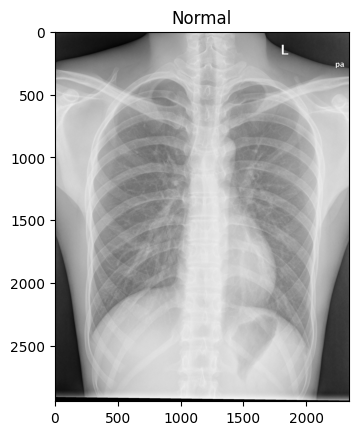

In [ ]:
plt.title('Normal')
plt.imshow(image.load_img(np.random.choice(normal)))
plt.show()

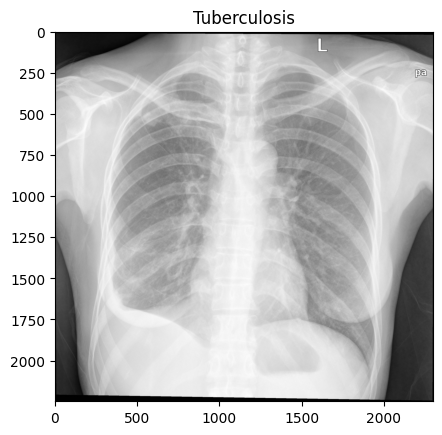

In [ ]:
plt.title('Tuberculosis')
plt.imshow(image.load_img(np.random.choice(tuberculosis)))
plt.show()

# Image Processing and Data Partition into Train and Test

In [ ]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_data_gen = datagen.flow_from_directory(directory='/content/dataset/train',
                                             target_size = (img_width, img_height),
                                             class_mode = 'sparse')
test_data_gen = datagen.flow_from_directory(directory='/content/dataset/test',
                                            target_size = (img_width, img_height),
                                             class_mode = 'sparse',)

Found 528 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


# Deep Learning Model

In [ ]:
model = Sequential()

#convolution 
model.add(Conv2D(32, (3,3), input_shape = (img_width, img_height, 3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

#Dense 
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(228, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(270, activation='relu'))
model.add(Dropout(0.3))



model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
r = model.fit_generator(generator=train_data_gen, 
                              steps_per_epoch=len(train_data_gen),
                              epochs=20, 
                              validation_data= test_data_gen, 
                              validation_steps = len(test_data_gen))

<ipython-input-29-6f25fa214ba6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_data_gen,


Epoch 1/20
17/17 [==============================] - 135s 8s/step - loss: 0.6962 - accuracy: 0.5227 - val_loss: 0.6932 - val_accuracy: 0.5075
Epoch 2/20
17/17 [==============================] - 107s 6s/step - loss: 0.6970 - accuracy: 0.5019 - val_loss: 0.6927 - val_accuracy: 0.5075
Epoch 3/20
17/17 [==============================] - 110s 6s/step - loss: 0.6950 - accuracy: 0.4981 - val_loss: 0.6925 - val_accuracy: 0.5672
Epoch 4/20
17/17 [==============================] - 99s 6s/step - loss: 0.6752 - accuracy: 0.5947 - val_loss: 0.6329 - val_accuracy: 0.7239
Epoch 5/20
17/17 [==============================] - 99s 6s/step - loss: 0.5516 - accuracy: 0.7557 - val_loss: 0.5223 - val_accuracy: 0.8060
Epoch 6/20
17/17 [==============================] - 95s 6s/step - loss: 0.4792 - accuracy: 0.8087 - val_loss: 0.5114 - val_accuracy: 0.8134
Epoch 7/20
17/17 [==============================] - 106s 6s/step - loss: 0.4782 - accuracy: 0.8106 - val_loss: 0.4679 - val_accuracy: 0.8284
Epoch 8/20
17/17

# Analysis/Evaluation 

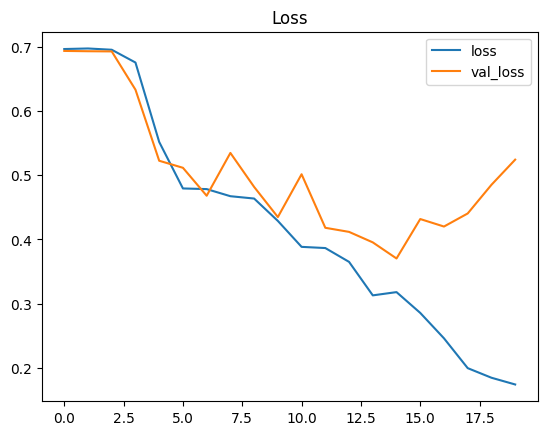

In [ ]:
plt.title('Loss')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

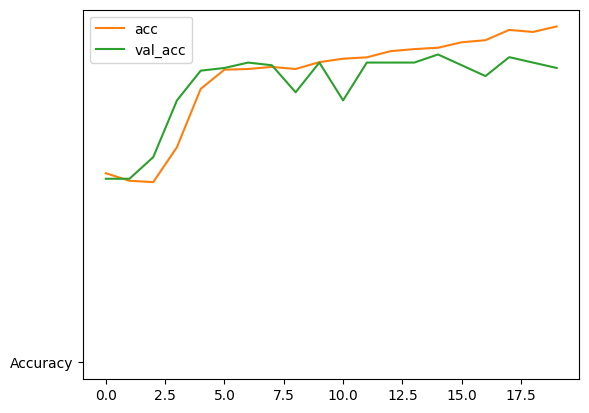

In [ ]:
#@title
plt.plot('Accuracy')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

# Evaluation and Confusion Matrix

Test Accuracy: 81.34%
5/5 [==============================] - 16s 3s/step
Confusion Matrix:
[[35 31]
 [36 32]]


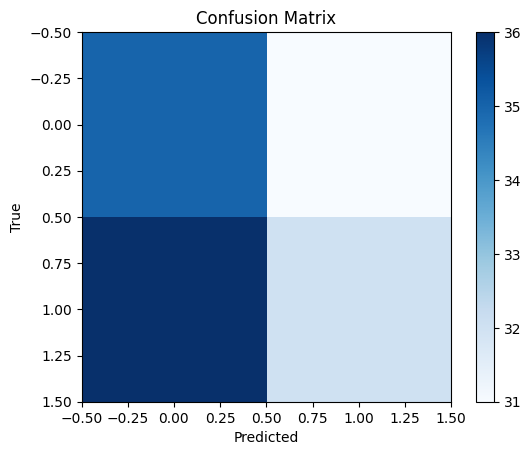

In [ ]:
# Evaluate the model
_, accuracy = model.evaluate(test_data_gen, verbose=0)
print('Test Accuracy: %.2f%%' % (accuracy * 100))

# Get predictions
y_pred = model.predict(test_data_gen)
y_pred = np.round(y_pred).flatten()

# Get true labels
y_true = test_data_gen.labels

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Saving the Model


In [ ]:
model.save('Tuberculosis.h5')

In [ ]:
model = tf.keras.models.load_model("Tuberculosis.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('Tuberculosis.tflite', 'wb').write(tflite_model)

9593220

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/Tuberculosis.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
image_path = "/content/test1.jpg"
image = Image.open(image_path).resize((150, 150))
image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
image = image.astype(np.float32)  # Convert to float32
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Set the image as the input to the model
interpreter.set_tensor(input_details[0]['index'], image)

# Run the inference
interpreter.invoke()

# Get the predicted probabilities
output = interpreter.get_tensor(output_details[0]['index'])
predicted_probability = output[0][0]  # Assuming single output node

# Define the threshold for classification
threshold = 0.5

# Make the prediction
if predicted_probability > threshold:
    prediction = "Tuberculosis"
else:
    prediction = "Healthy"

print("Prediction:", prediction)
print("Probability:", predicted_probability)


FileNotFoundError: ignored